# ĐỒ ÁN CUỐI KÌ DS106.
Expectigrad

## Chuẩn bị dữ liệu

In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
# 1. Bộ dữ liệu
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


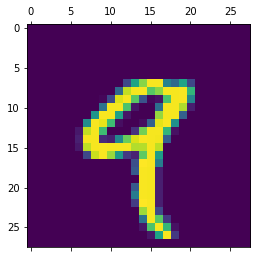

In [ ]:
plt.matshow(X_train[4])

In [ ]:
# Kich thuoc du lieu test.
y_train.shape
X_train.shape

(60000, 28, 28)

In [ ]:
# 2. Chuẩn bị dữ liệu.
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X_train,
y_train, test_size=0.1)

In [ ]:
# Reshape data:
X_train_reshaped = X_train.reshape(-1, 784)
X_dev_reshaped = X_dev.reshape(-1, 784)
X_test_reshaped = X_test.reshape(-1, 784)

In [ ]:
X_train_reshaped.shape

(54000, 784)

In [ ]:
# Chuẩn bị y_train và y_dev:
from tensorflow.keras.utils import to_categorical
y_train_new = to_categorical(y_train,num_classes=10)
y_dev_new = to_categorical(y_dev, num_classes = 10)

In [ ]:
y_train_new.shape

(54000, 10)

## THỰC HIỆN THUẬT TOÁN. 

In [ ]:
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops


class Expectigrad(optimizer_v2.OptimizerV2):
    """TensorFlow 2.x Optimizer that implements the Expectigrad algorithm."""

    def __init__(self, learning_rate=0.001, beta=0.9, epsilon=1e-8, sparse_counter=True,
                 name='Expectigrad', **kwargs):
        """Instantiates the Expectigrad optimizer.
        Args:
            learning_rate: The learning rate, a scale factor applied to each optimizer
                step. Can be a float, `tf.keras.optimizers.schedules.LearningRateSchedule`,
                `Tensor`, or callable that takes no arguments and returns the value to use.
                Default: 0.001
            beta (float): The decay rate for Expectigrad's bias-corrected, "outer"
                momentum. Must be in the interval [0, 1). Default: 0.9
            epsilon (float): A small constant added to the denominator for numerical
                stability. Must be greater than 0. Default: 1e-8
            sparse_counter (bool): If True, Expectigrad's counter increments only where
                the gradient is nonzero. If False, the counter increments unconditionally.
                Default: True
            name (str): Optional name for the operations created when applying gradients.
                Default: 'Expectigrad'
            **kwargs: Keyword arguments. Allowed to be {`clipnorm`, `clipvalue`, `lr`,
                `decay`}. `clipnorm` is gradient clipping by norm; `clipvalue` is
                gradient clipping by value; `decay` is included for backward
                compatibility to allow time inverse decay of learning rate; `lr` is
                included for backward compatibility, recommended to use `learning_rate`
                instead.
        Raises:
            ValueError: beta is not in the interval [0, 1) or epsilon is nonpositive.
        """
        super(Expectigrad, self).__init__(name, **kwargs)

        if not (0.0 <= beta < 1.0):
            raise ValueError("beta must be in [0,1) but got {}".format(beta))
        if epsilon <= 0.0:
            raise ValueError("epsilon must be greater than 0 but got {}".format(epsilon))

        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._beta = beta
        self._epsilon = epsilon
        self._use_momentum = (beta > 0.0)
        self._sparse_counter = sparse_counter

    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, 'sum')
            if self._sparse_counter:
                self.add_slot(var, 'counter')
            if self._use_momentum:
                self.add_slot(var, 'momentum')

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_dtype = var.dtype.base_dtype

        lr = self._decayed_lr(var_dtype)
        beta = self._beta
        epsilon = self._epsilon
        t = math_ops.cast(self.iterations + 1, var_dtype)

        ops = []

        # Update running sum
        s = self.get_slot(var, 'sum')
        grad_sq = math_ops.square(grad)
        s_new = s + grad_sq
        ops.append(state_ops.assign(s, s_new))

        # Update running counter
        if self._sparse_counter:
            n = self.get_slot(var, 'counter')
            n_new = n + math_ops.sign(grad_sq)
            ops.append(state_ops.assign(n, n_new))
        else:
            # Counter is not sparse; just use the current timestep instead
            n_new = t

        # Compute step size
        average = math_ops.div_no_nan(s_new, n_new)
        step = grad / (epsilon + math_ops.sqrt(average))

        # Update momentum
        if self._use_momentum:
            m = self.get_slot(var, 'momentum')
            m_new = beta * m + (1.0 - beta) * step
            ops.append(state_ops.assign(m, m_new))
            # Bias correction
            lr = lr / (1.0 - pow(beta, t))
        else:
            # No momentum; just use the current step instead
            m_new = step

        # Update parameters
        ops.append(state_ops.assign_sub(var, lr * m_new))
        return control_flow_ops.group(*ops)

    def get_config(self):
        config = super(Expectigrad, self).get_config()
        config.update({'learning_rate': self._serialize_hyperparameter('learning_rate'),
                       'beta': self._beta,
                       'epsilon': self._epsilon,
                       'use_momentum': self._use_momentum,
                       'sparse_counter': self._sparse_counter})
        return config

In [ ]:
# 3. Huấn luyện mô hình.
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.losses import CategoricalCrossentropy
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.metrics import Accuracy
model = Sequential()

model.add(Dense(784, input_shape=(784, ),
                activation='relu'
                #kernel_regularizer = l2(0.01),
                #bias_regularizer= l2(0.01))
))
model.add(Dense(10, input_shape=(10, ),
                activation='sigmoid'
                #kernel_regularizer= l2(0.01),
                #bias_regularizer= l2(0.01) )
))

optimizer = Expectigrad(lr=10)
loss = CategoricalCrossentropy()
metrics = Accuracy()
model.compile(optimizer=optimizer, loss='mse', metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:368: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Chay mo hinh
history = model.fit(X_train_reshaped, y_train_new,
validation_data=(X_dev_reshaped,y_dev_new) ,batch_size=128, epochs=30)

Epoch 1/30
422/422 [==============================] - 7s 9ms/step - loss: 0.1013 - accuracy: 0.8981 - val_loss: 0.1000 - val_accuracy: 0.9000
Epoch 2/30
422/422 [==============================] - 4s 9ms/step - loss: 0.1000 - accuracy: 0.9000 - val_loss: 0.1000 - val_accuracy: 0.9000
Epoch 3/30
422/422 [==============================] - 4s 9ms/step - loss: 0.1000 - accuracy: 0.9000 - val_loss: 0.1000 - val_accuracy: 0.9000
Epoch 4/30
422/422 [==============================] - 4s 9ms/step - loss: 0.1000 - accuracy: 0.9000 - val_loss: 0.1000 - val_accuracy: 0.9000
Epoch 5/30
422/422 [==============================] - 2s 6ms/step - loss: 0.1000 - accuracy: 0.9000 - val_loss: 0.1000 - val_accuracy: 0.9000
Epoch 6/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1000 - accuracy: 0.9000 - val_loss: 0.1000 - val_accuracy: 0.9000
Epoch 7/30
422/422 [==============================] - 2s 5ms/step - loss: 0.1000 - accuracy: 0.9000 - val_loss: 0.1000 - val_accuracy: 0.9000
Epoch 

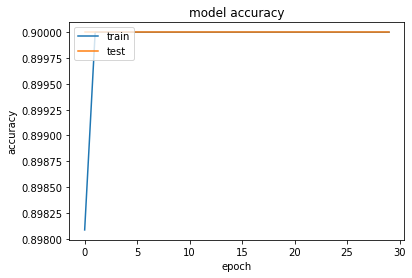

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

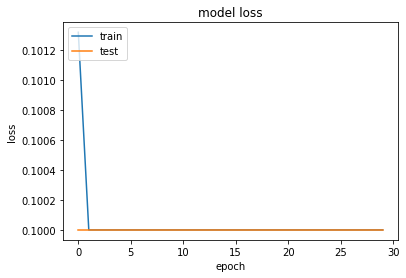

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
